# PDE-Learning of non-interacting fermions dynamics: Learning continuity and Euler Equations

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import *
from utils import save_dict, load_dict
from utils import generalized_euler_solver, get_euler_term_from_descr

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Here we consider fermion dynamics in 1D tight-binding model with the Hamiltonian:
$$ H = -J \sum_i (c^{+}_i c_{i+1} + c^+_{i+1} c_i),$$
where $J$ is the hopping coefficient, $c^+_i$ ($c_i$) is the creation (annihilation) fermion operator. 

The physical observables of interest are the particle density $\rho(t,i) = \langle c^+_ic_i\rangle$ and velocity $v(t,i) = 2J\Im \langle c^+_{i+1} c_i\rangle/\rho(t,i)$.

## First, let's have a look at the dataset

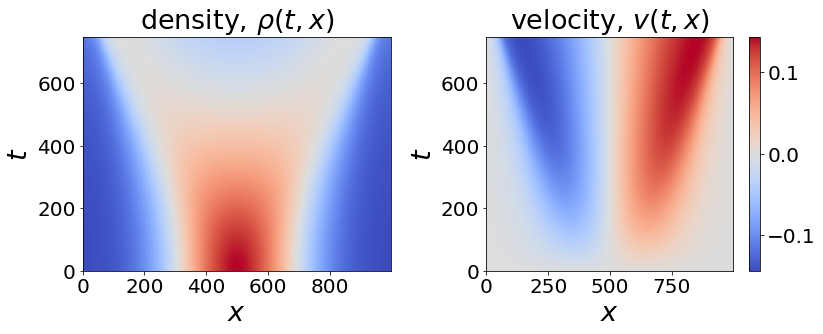

In [7]:
#-------------------------------------------------------
# Import data
fname ='./data/free_fermions_J1=-0.5_J2=0.0_L=1000.npy'
data_dict = load_dict(fname)
#-------------------------------------------------------

# Specifying time range
start, stop = 0, 1500

# Density
rho = data_dict['n']
# Velocity
v = data_dict['v']

# Temporal and Spatial points
t = data_dict['t']
x = data_dict['x']

# Plot data
xx, tt = np.meshgrid(x, t)
fig, ax = plt.subplots(1, 2, figsize = (12, 5));
plt_rho = ax[0].pcolormesh(xx, tt, rho, cmap='coolwarm')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'density, $\rho(t, x)$')

plt_v = ax[1].pcolormesh(xx, tt, v, cmap='coolwarm')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'velocity, $v(t, x)$')
fig.colorbar(plt_v, ax=ax[1])

fig.tight_layout(pad=2)

In [10]:
dt = t[1]-t[0]
dx = x[1]-x[0]
m, n = rho.shape
print('dt: ', dt, 'dx: ', dx)
print('Dataset dimensions: ', rho.shape)
print('Xmax, Tmax: ', x[-1], t[-1])

dt:  1.0 dx:  2
Dataset dimensions:  (750, 500)
Xmax, Tmax:  998 749.0


## Preparing library of candidate terms:

In [12]:
#-----------------------------------------------------------------------------
# Define symbolic expressions for the candidate terms in v_t=G(...)
#-----------------------------------------------------------------------------
v_descr = [
          'rho_x',
           'v*v_x',
           'v^2*rho_x',
           'v^2*rho*rho_x',
           'v^2*rho^2*rho_x',
           'v^2*rho^3*rho_x',
           'v^2*rho^4*rho_x',
           'v^2*rho^5*rho_x',
           'v^2*rho_x*1/rho',
           'rho*v*v_x',
           'rho^2*v*v_x',
           'rho^3*v*v_x',
           'rho^4*v*v_x', 
           'rho^5*v*v_x', 
           'rho*rho_x', 
           'rho^2*rho_x', 
           'rho^3*rho_x',
           'rho^4*rho_x',
           'rho^5*rho_x',]

#-----------------------------------------------------------------------------
# Define boundary conditions, needed for evaluation of spatial derivatives
bc = "periodic"
#-----------------------------------------------------------------------------
# Compute temporal and spatial derivatives and build Theta(U) matrix
rhot = TotalFiniteDiff_t(rho, dt).reshape((n*m,1))
vt = TotalFiniteDiff_t(v, dt).reshape((n*m,1))
#-----------------------------------------------------------------------------
v_data = []

# Stack columns with the vectorized candidate terms to form matrix Theta(U)
for term in v_descr:
    v_data.append(get_euler_term_from_descr(term, rho, v, x, bc).reshape((n*m,1)))

v_data = np.hstack(v_data)
v_Theta, v_descr = build_custom_Theta(v_data, v_descr)

In [13]:
#-----------------------------------------------------------------------------
# Define symbolic expressions for the candidate terms in rho_t=F(...)
#-----------------------------------------------------------------------------

rho_descr = [ 'rho',
              'v',
              'rho_x',
              'v_x',
              'v*v_x',
              'rho*rho_x',
              'v*rho_x',
              'rho*v_x',
              'rho*v*rho_x',
              'rho^2*v_x',    
              'rho^2*v*rho_x',
              'rho^3*v_x',    
              'rho^3*v*rho_x',
              'rho^4*v_x',  
            ]

rho_data = []

# Stack columns with the vectorized candidate terms to form matrix Theta(U)
for term in rho_descr:
    rho_data.append(get_euler_term_from_descr(term, rho, v, x, bc).reshape((n*m,1)))

rho_data = np.hstack(rho_data)
rho_Theta, rho_descr = build_custom_Theta(rho_data, rho_descr)

In [14]:
print(r"Total number of terms for $rho_t=F(.)$:", len(rho_descr))
print(r"Total number of terms for $v_t=G(.)$:", len(v_descr))

Total number of terms for $rho_t=F(.)$: 14
Total number of terms for $v_t=G(.)$: 19


## Search PDE for density: $\rho_t = F(...)$

In [15]:
xi_rho, _ = BruteForceL0(rho_Theta, rhot, rho_descr, l0_penalty=1e-3, lam_l2=0, 
                     verbose=False, lhs_descr='rho_t')

Best PDE found with BruteForce:
rho_t = (-1.000690 +0.000000i)v*rho_x
    + (-0.999997 +0.000000i)rho*v_x
   
Time elapsed (s): 4.195709943771362


 We receovered the continuity equation!

## Search PDE for velocity: $v_t = G(...)$

In [16]:
# Computation may take a while (~10 mins)
xi_v, _ = BruteForceL0(v_Theta, vt, v_descr, l0_penalty=1e-3, lam_l2=0, verbose=False, lhs_descr='v_t')

Best PDE found with BruteForce:
v_t = (-0.951824 +0.000000i)v*v_x
    + (-9.433596 +0.000000i)rho*rho_x
   
Time elapsed (s): 55.08295392990112


The discovered system of equations is very close to the semiclassical equations of motion for the ideal Fermi gas:
$$\begin{cases}
\rho_t+(\rho v)_x = 0,\\
v_t+v v_x + \frac{\pi^2}{m^2}\rho \rho_x = 0,
\end{cases}
$$
where $m=1/(2J)=1$ is the fermion mass.

## Compare data and the solution of the inferred hydrodynamic PDE

In [19]:
rho_ev, v_ev = generalized_euler_solver(v_descr, xi_v.real, 
                                        rho[0], v[0], t, x, 
                                        num_integrator_steps=50, 
                                        fix_vvx_term=False)

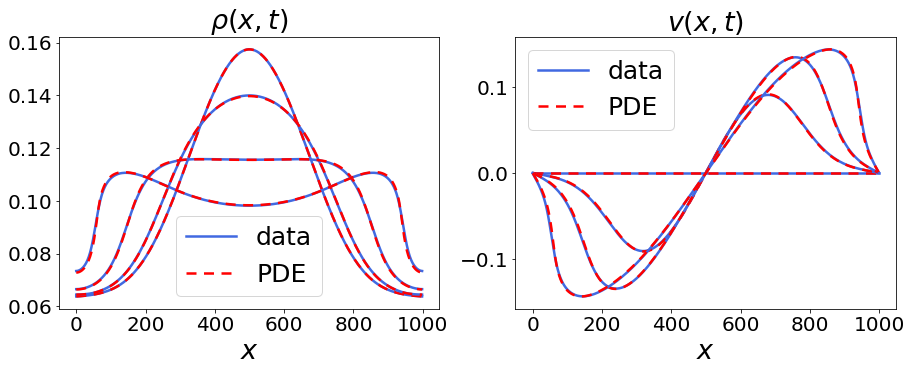

In [24]:
time_points = [0, 250, 500, -1] 
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

for i, indx in enumerate(time_points):
    if i == 0:
        label1, label2 = 'data', 'PDE'
    else:
        label1, label2 = '', ''
    ax[0].plot(x, rho[indx, :],
             c='royalblue', label=label1)
    ax[0].plot(x, rho_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)

    ax[1].plot(x, v[indx, :],
             c='royalblue', label=label1)
    ax[1].plot(x, v_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)

ax[0].legend()
ax[0].set_xlabel(r'$x$')
ax[0].set_title(r'$\rho(x, t)$')

ax[1].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_title(r'$v(x, t)$')

plt.show()
fig.tight_layout(pad=3)

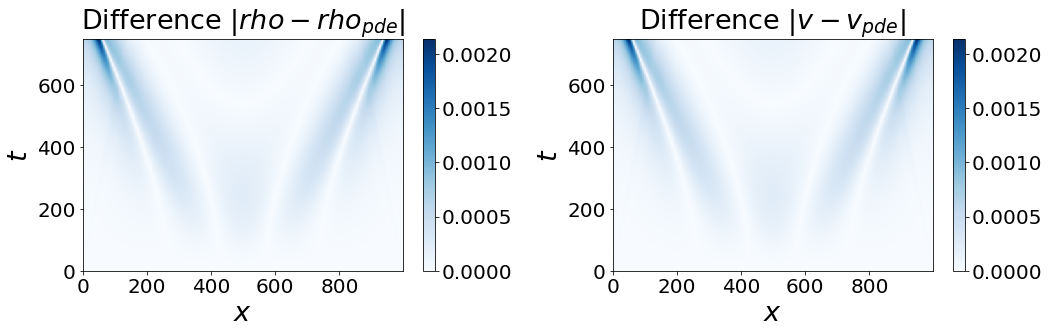

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
plt_rho = ax[0].pcolormesh(xx, tt, abs(rho-rho_ev), cmap='Blues', rasterized=True)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'Difference $|rho-rho_{pde}|$')
fig.colorbar(plt_rho, ax=ax[0])

plt_v = ax[1].pcolormesh(xx, tt, abs(rho-rho_ev), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|v-v_{pde}|$')
fig.colorbar(plt_v, ax=ax[1])
fig.tight_layout(pad=2)